# Blackbird Motor Estimations

This notebook is for looking at the forces and moments generated by the motors and see how well they matched up with the expected theoretical model presented.

## Loading the Dataset

First thing to do is to load in the dataset and apply corrections and methods examined from the Force Estimation and Rotation Angles notebooks.

In [1]:
import importlib
import os
import sys
import time
# sys.path.append(os.path.abspath('../functions'))

from thesis.data import blackbird_dataset as rbd
from thesis.modules import dsp, quaternions

%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [3]:
t1 = time.time()
test_df = rbd.read_blackbird_test('figure8', 'Constant', 0.5)
print("Time elapsed: %f" % (time.time() - t1))

Time elapsed: 21.836220


In [4]:
importlib.reload(rbd)
t1 = time.time()
rbd.imu_installation_correction(test_df)
t2 = time.time()
test_df = rbd.inertial_position_derivatives_estimation(test_df)
t3 = time.time()
test_df = rbd.gyroscope_derivatives_estimation(test_df)
t4 = time.time()
test_df = rbd.consistent_quaternions(test_df)
t5 = time.time()
test_df = rbd.inertial_quaternion_derivatives_estimation(test_df)
t6 = time.time()
test_df = rbd.body_quaternion_angular_derivative_estimate(test_df)
t7 = time.time()

print('Time elapsed breakdown')
print('\tIMU correction = %f [s]' % (t2 - t1))
print('\tInertial position derivative estimates = %f [s]' % (t3 - t2))
print('\tGyroscope derivative estimates = %f [s]' % (t4 - t3))
print('\tConsistent quaternions = %f [s]' % (t5 - t4))
print('\tQuaternion derivate estimates = %f [s]' % (t6 - t5))
print('\tBody rates from quaternion derivatives = %f [s]' % (t7-t6))
print('Total time elapsed = %f' % (t7 - t1))

# test_df.info()

Time elapsed breakdown
	IMU correction = 0.232892 [s]
	Inertial position derivative estimates = 112.238546 [s]
	Gyroscope derivative estimates = 30.036455 [s]
	Consistent quaternions = 2.084783 [s]
	Quaternion derivate estimates = 147.476556 [s]
	Body rates from quaternion derivatives = 3.315088 [s]
Total time elapsed = 295.384320


In [5]:
# Getting rid of excess indices
test_df = test_df.groupby(level=0).sum().replace(0., np.nan)

## Transform Inertial Frame Derivatives to Body Frame

Since the motors are rigidly attached to the frame, all translational and rotational accelerations should be in the body frame for all estimations.

In [6]:
# Get Inertial frame measurements
quaternions_inertial_df = test_df[['qw_est',
                                   'qx_est',
                                   'qy_est',
                                   'qz_est',
                                   'px_[m]_est',
                                   'py_[m]_est',
                                   'pz_[m]_est',
                                   'vx_I_[m/s]',
                                   'vy_I_[m/s]',
                                   'vz_I_[m/s]',
                                   'ax_I_[m/s2]',
                                   'ay_I_[m/s2]',
                                   'az_I_[m/s2]']].dropna()

# Get Body frame measurements
quaternions_body_df = test_df[['omegax_qest',
                               'omegay_qest',
                               'omegaz_qest',
                               'omegadotx_qest',
                               'omegadoty_qest',
                               'omegadotz_qest']].dropna()

# Get a spare index
q_index = quaternions_body_df.index

# Time vector from index
rbts2s = 10 ** -9
t_q = (q_index - test_df.index[0]) * rbts2s
t_q = t_q.astype('float')

# Reset Index
quaternions_inertial_df = quaternions_inertial_df.reset_index()
quaternions_body_df = quaternions_body_df.reset_index()

In [7]:
def cross_product_skew_symmetric_matrix(x, y, z):
    CROSS = np.array([[0, -y, z],
                      [y, 0, -x],
                      [-z, x, 0]])
    return CROSS

# Constants
vehicle = rbd.BlackbirdVehicle()
g = 9.81 # [m/s2]
Inertia = vehicle.get_inertia_matrix()
Iinv = np.linalg.inv(Inertia)

# Preallocate body value matrices matrix
V_B = np.zeros((len(quaternions_body_df.index), 3)) # Vehicle velocity in body frame
a_B = np.zeros((len(quaternions_body_df.index), 3)) # Used against IMU to benchmark quaternion based accuracy
omegadot_B = np.zeros((len(quaternions_body_df.index), 3))

# Inertial frame acceleration in body frame. All body effects sum to this
a_I_B = np.zeros((len(quaternions_body_df.index), 3))
a_transport_B = np.zeros((len(quaternions_body_df.index), 3)) # omega cross v from transport equation
a_gravity_B = np.zeros((len(quaternions_body_df.index), 3)) # Gravity in body frame

# Inertial frame rotational derivative in body. All body effects sum to this
omegadot_I_B = np.zeros((len(quaternions_body_df.index), 3))
# omega cross (I times omega) from transport equation
omegadot_transport_B = np.zeros((len(quaternions_body_df.index), 3)) 

# Transform Inertial frame into Body Frame
for i in range(len(quaternions_inertial_df.index)):
    # Get Rotation matrix from quaternions
    qw = quaternions_inertial_df.loc[i, 'qw_est']
    qx = quaternions_inertial_df.loc[i, 'qx_est']
    qy = quaternions_inertial_df.loc[i, 'qy_est']
    qz = quaternions_inertial_df.loc[i, 'qz_est']
    R = quaternions.Rmatrix_from_quaternions(qw, qx, qy, qz)

    # Get inertial frame velocity and acceleration
    vx = quaternions_inertial_df.loc[i, 'vx_I_[m/s]']
    vy = quaternions_inertial_df.loc[i, 'vy_I_[m/s]']
    vz = quaternions_inertial_df.loc[i, 'vz_I_[m/s]']
    ax = quaternions_inertial_df.loc[i, 'ax_I_[m/s2]']
    ay = quaternions_inertial_df.loc[i, 'ay_I_[m/s2]']
    az = quaternions_inertial_df.loc[i, 'az_I_[m/s2]']

    # Get rotation rates and accelerations from body frame
    omegax = quaternions_body_df.loc[i, 'omegax_qest']
    omegay = quaternions_body_df.loc[i, 'omegay_qest']
    omegaz = quaternions_body_df.loc[i, 'omegaz_qest']
    omegadotx = quaternions_body_df.loc[i, 'omegadotx_qest']
    omegadoty = quaternions_body_df.loc[i, 'omegadoty_qest']
    omegadotz = quaternions_body_df.loc[i, 'omegadotz_qest']

    # Get cross product equivalent matrix
    OmegaCross = cross_product_skew_symmetric_matrix(omegax, omegay, omegaz)
    
    # Transform velocity from inertial into body
    V_I = np.array([vx, vy, vz]).T
    V_B[i] = np.matmul(R, V_I).T
    
    # Transform translational acceleration (a_B = a_I|B - omega cross v_B)
    a_I = np.array([ax, ay, az]).T
    a_I_B[i] = np.matmul(R, a_I).T
    a_transport_B[i] = np.matmul(OmegaCross, V_B[i]).T
    a_B[i] = a_I_B[i] - a_transport_B[i]
    a_gravity_B[i] = np.matmul(R, np.array([0, 0, g]).T)
    
    # Transform rotational acceleration (alpha_B = alpha_I|B - Iinv (omega cross (I omega)))
    omega = np.array([omegax, omegay, omegaz]).T
    omegadot_I_B[i] = np.array([omegadotx, omegadoty, omegadotz]).T
    omegadot_transport_B[i] = np.matmul(Iinv, np.matmul(OmegaCross, np.matmul(Inertia, omega)))

quaternions_body_df['vx_B_[m/s]'] = V_B[:, 0]
quaternions_body_df['vy_B_[m/s]'] = V_B[:, 1]
quaternions_body_df['vz_B_[m/s]'] = V_B[:, 2]
quaternions_body_df['ax_B_[m/s2]'] = a_B[:, 0]
quaternions_body_df['ay_B_[m/s2]'] = a_B[:, 1]
quaternions_body_df['az_B_[m/s2]'] = a_B[:, 2]
quaternions_body_df['ax_g|B_[m/s2]'] = a_gravity_B[:,0]
quaternions_body_df['ay_g|B_[m/s2]'] = a_gravity_B[:,1]
quaternions_body_df['az_g|B_[m/s2]'] = a_gravity_B[:,2]
quaternions_body_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77287 entries, 0 to 77286
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rosbagTimestamp  77287 non-null  int64  
 1   omegax_qest      77287 non-null  float64
 2   omegay_qest      77287 non-null  float64
 3   omegaz_qest      77287 non-null  float64
 4   omegadotx_qest   77287 non-null  float64
 5   omegadoty_qest   77287 non-null  float64
 6   omegadotz_qest   77287 non-null  float64
 7   vx_B_[m/s]       77287 non-null  float64
 8   vy_B_[m/s]       77287 non-null  float64
 9   vz_B_[m/s]       77287 non-null  float64
 10  ax_B_[m/s2]      77287 non-null  float64
 11  ay_B_[m/s2]      77287 non-null  float64
 12  az_B_[m/s2]      77287 non-null  float64
 13  ax_g|B_[m/s2]    77287 non-null  float64
 14  ay_g|B_[m/s2]    77287 non-null  float64
 15  az_g|B_[m/s2]    77287 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 9.4 MB


In [8]:
a_imu = test_df[['ax_[m/s2]', 'ay_[m/s2]', 'az_[m/s2]']].dropna()
t_imu = (a_imu.index - test_df.index[0]).values * rbts2s
t_imu = t_imu.astype('float')
a_imu = a_imu.values

print(t_imu)
print(a_imu)

[  1.759351   1.769346   1.779572 ... 214.709508 214.719489 214.729519]
[[ 0.39224178  0.05371109 -9.74158382]
 [ 0.39395699  0.05321441 -9.76864719]
 [ 0.40324804  0.05694842 -9.74429131]
 ...
 [ 0.47276697  0.03919758 -9.70391941]
 [ 0.47823358  0.04428208 -9.69078064]
 [ 0.46408102  0.0645295  -9.68992043]]


<IPython.core.display.Javascript object>


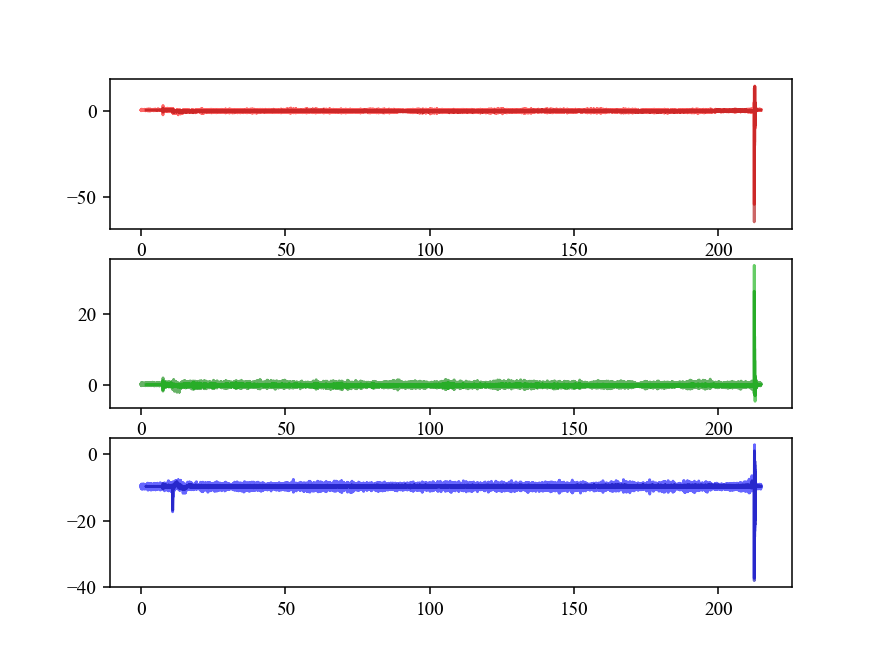

In [9]:
fig, ax = plt.subplots(3,1)

ax[0].plot(t_q, a_B[:,0] - a_gravity_B[:,0], color='r', alpha=0.6)
ax[0].plot(t_imu, a_imu[:,0], color='#aa0000', alpha=0.6)
ax[1].plot(t_q, a_B[:,1] - a_gravity_B[:,1], color='g', alpha=0.6)
ax[1].plot(t_imu, a_imu[:,1], color='#00aa00', alpha=0.6)
ax[2].plot(t_q, a_B[:,2] - a_gravity_B[:,2], color='b', alpha=0.6)
ax[2].plot(t_imu, a_imu[:,2], color='#0000aa', alpha=0.6)

plt.show()

In [10]:
omega_gyro = test_df[['omegax_[dps]', 'omegay_[dps]', 'omegaz_[dps]']].dropna()
omegadot_gyro = test_df[['omegadotx_est', 'omegadoty_est', 'omegadotz_est']].dropna()
t_gyro = (omega_gyro.index - test_df.index[0]).values * rbts2s
t_gyro = t_gyro.astype('float')
omega_gyro = omega_gyro.values
omegadot_gyro = omegadot_gyro.values

print(t_gyro)
print(omega_gyro)

[  1.759351   1.769346   1.779572 ... 214.709508 214.719489 214.729519]
[[-1.21071935e-05 -8.28057621e-03 -4.59998846e-03]
 [-1.82148069e-03 -7.90655613e-03 -4.60110605e-03]
 [-1.41821802e-03 -7.32466578e-03 -4.68604267e-03]
 ...
 [-1.65831298e-03 -6.91637397e-03 -4.11309302e-03]
 [-8.36513937e-04 -7.76164234e-03 -7.09742308e-03]
 [ 1.10231340e-03 -7.42338598e-03 -4.07323195e-03]]


<IPython.core.display.Javascript object>


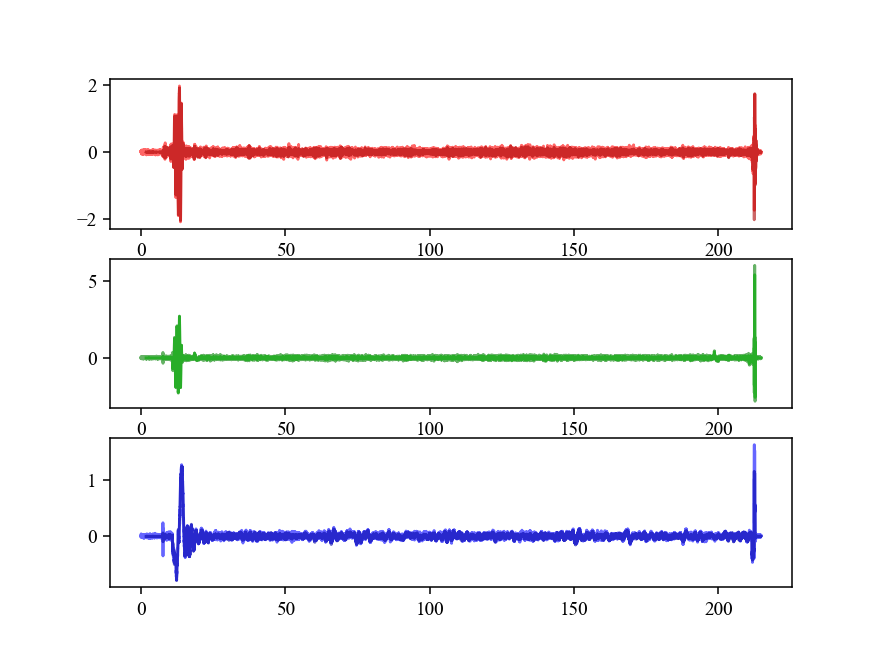

In [11]:
fig, ax = plt.subplots(3,1)

ax[0].plot(t_q, quaternions_body_df['omegax_qest'].values, color='r', alpha=0.6)
ax[0].plot(t_gyro, omega_gyro[:,0], color='#aa0000', alpha=0.6)
ax[1].plot(t_q, quaternions_body_df['omegay_qest'].values, color='g', alpha=0.6)
ax[1].plot(t_gyro, omega_gyro[:,1], color='#00aa00', alpha=0.6)
ax[2].plot(t_q, quaternions_body_df['omegaz_qest'].values, color='b', alpha=0.6)
ax[2].plot(t_gyro, omega_gyro[:,2], color='#0000aa', alpha=0.6)

plt.show()

### Determining In-flight versus Grounded

In order to account for the ground providing the counter gravitational force, it is necessary to determine when the vehicle is on the ground. Options evaluated in this order:

1. Z-position based solely on maximum
2. Z-position from start/ends of the time history assuming the quadcopter starts/ends on the ground

<IPython.core.display.Javascript object>


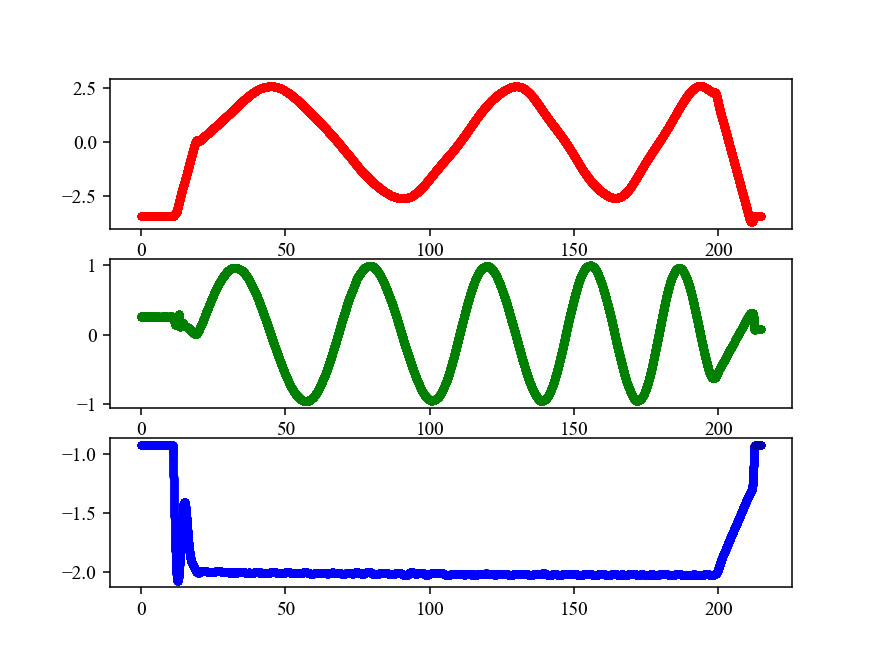

In [12]:
# Find out when its on the ground for zeroing acceleration

z_ground = quaternions_inertial_df['pz_[m]_est'].max()
delta_z = 0.001

p = quaternions_inertial_df[['px_[m]_est', 'py_[m]_est', 'pz_[m]_est']].values
ind_ground = p[:, 2] >= z_ground - delta_z

fig, ax = plt.subplots(3, 1)

ax[0].scatter(t_q, p[:, 0], color='r', marker='.')
ax[1].scatter(t_q, p[:, 1], color='g', marker='.')
ax[2].scatter(t_q, p[:, 2], color='b', marker='.')
ax[2].scatter(t_q[ind_ground], p[ind_ground, 2], color='#0000aa', marker='.')

plt.show()

Looks like there is some variation in floor that prevents the level of accuracy that would be nice ... go figure. Trying option 2.

<IPython.core.display.Javascript object>


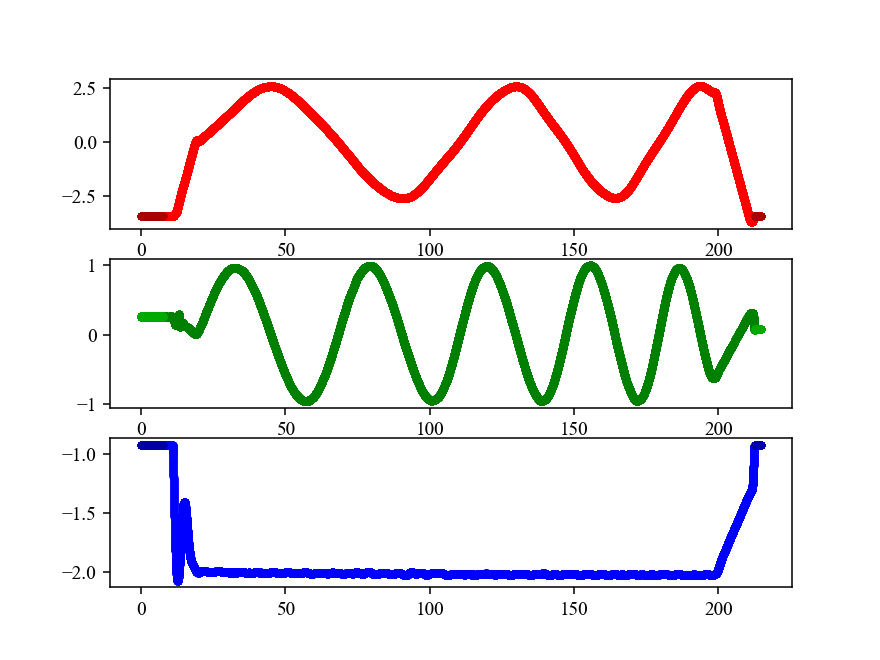

In [13]:
# Find out when its on the ground for zeroing acceleration

delta_z = 0.00025

num_p = p.shape[0]

i_ground_start = (p[:, 2] >= p[0, 2] - delta_z) & (t_q < t_q[int(len(t_q)/2)])
i_ground_stop = (p[:, 2] >= p[-1, 2] - delta_z) & (t_q > t_q[int(len(t_q)/2)])
i_ground = i_ground_start | i_ground_stop

fig, ax = plt.subplots(3, 1)

ax[0].scatter(t_q, p[:, 0], color='r', marker='.')
ax[0].scatter(t_q[i_ground], p[i_ground, 0], color='#aa0000', marker='.')
ax[1].scatter(t_q, p[:, 1], color='g', marker='.')
ax[1].scatter(t_q[i_ground], p[i_ground, 1], color='#00aa00', marker='.')
ax[2].scatter(t_q, p[:, 2], color='b', marker='.')
ax[2].scatter(t_q[i_ground], p[i_ground, 2], color='#0000aa', marker='.')


plt.show()

<IPython.core.display.Javascript object>


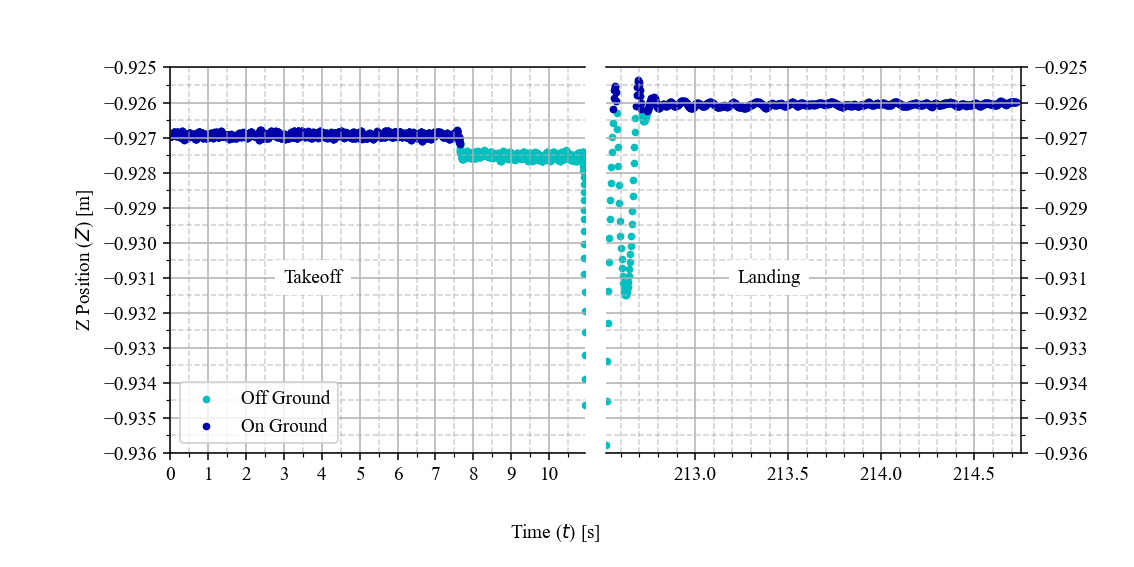

In [14]:
tstart1, tstop1 = 0, 10.95
tstart2, tstop2 = 212.52, 214.75

ind1 = t_q <= tstop1
ind2 = t_q >= tstart2

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(6,3)
fig.subplots_adjust(left=0.15, bottom=0.2, wspace=0.05)

ax[0].scatter(
    t_q[ind1],
    p[ind1, 2],
    color='c', marker='.',
    label='Off Ground'
)
ax[0].scatter(
    t_q[np.logical_and(i_ground, ind1)],
    p[np.logical_and(i_ground, ind1), 2],
    color='#0000aa', marker='.',
    label='On Ground'
)
ax[1].scatter(t_q[ind2], p[ind2, 2], color='c', marker='.')
ax[1].scatter(t_q[np.logical_and(i_ground, ind2)], p[np.logical_and(i_ground, ind2), 2], color='#0000aa', marker='.')

# Get y lims
yl = ax[0].get_ylim()
yr = ax[1].get_ylim()
ymin, ymax = min(yl[0], yr[0]), max(yl[1], yr[1])

ax[0].legend()

# Prettifying
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].set_ylabel("Z Position ($Z$) [m]")

ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[0].set_xlim(tstart1, tstop1)
ax[1].set_xlim(tstart2, tstop2)

ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax[1].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))

for a in ax:
    #a.set_ylim(bottom=ymin, top=ymax)
    a.set_ylim(bottom=-0.936, top=-0.925)
    a.yaxis.set_major_locator(ticker.MultipleLocator(0.001))
    a.yaxis.set_minor_locator(ticker.MultipleLocator(0.0005))
    
    a.grid(True, which='major')
    a.grid(True, which='minor', linestyle='--', alpha=0.6)
    
fig.text(0.45, 0.05, "Time ($t$) [s]")
fig.text(0.25, 0.5, "Takeoff", backgroundcolor='w')
fig.text(0.65, 0.5, "Landing", backgroundcolor='w')

fig.savefig("../report/project-report/figures/methodology/takeoff-landing-problem.png")

plt.show()

Option 2 looks to work well, constructing a -g force series from the ground indices to add in acceleration

In [15]:
# creating inertial frame matrix of acceleration due to ground ignoring friction along the surface
a_ground = np.zeros((i_ground.shape[0], 3))
a_ground[i_ground, 2] = -g # upwards acceleration

# Transform Inertial frame into Body Frame
for i in range(a_ground.shape[0]):
    # Get Rotation matrix from quaternions
    qw = quaternions_inertial_df.loc[i, 'qw_est']
    qx = quaternions_inertial_df.loc[i, 'qx_est']
    qy = quaternions_inertial_df.loc[i, 'qy_est']
    qz = quaternions_inertial_df.loc[i, 'qz_est']
    R = quaternions.Rmatrix_from_quaternions(qw, qx, qy, qz)
    a_ground[i] = np.matmul(R, a_ground[i].T).T

<IPython.core.display.Javascript object>


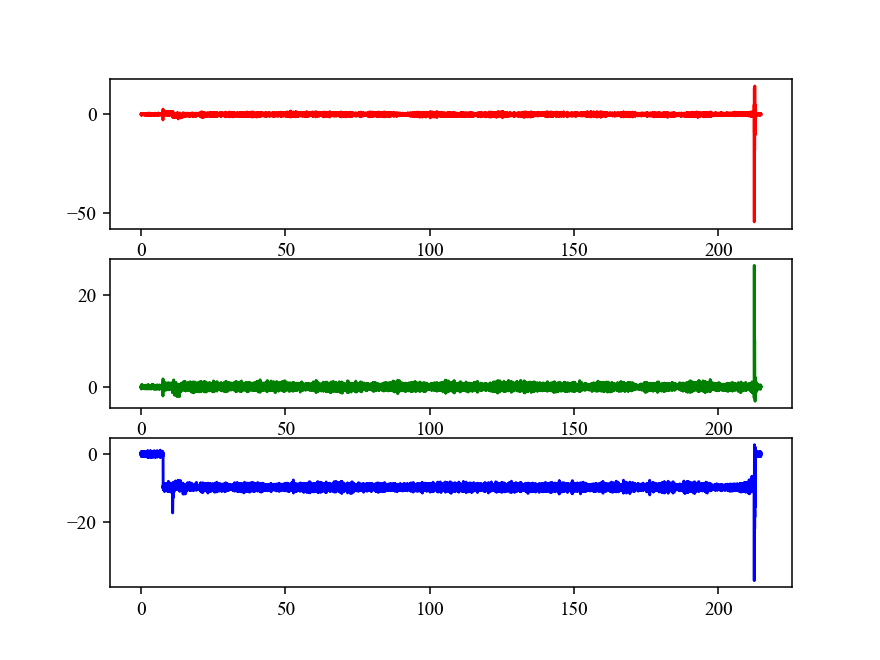

In [16]:
# Unexplained acceleration in the body frame
a_unexplained = a_I_B - (a_transport_B + a_gravity_B + a_ground)

fig, ax = plt.subplots(3, 1)

ax[0].plot(t_q, a_unexplained[:,0], color='r')
ax[1].plot(t_q, a_unexplained[:,1], color='g')
ax[2].plot(t_q, a_unexplained[:,2], color='b')

plt.show()

<IPython.core.display.Javascript object>


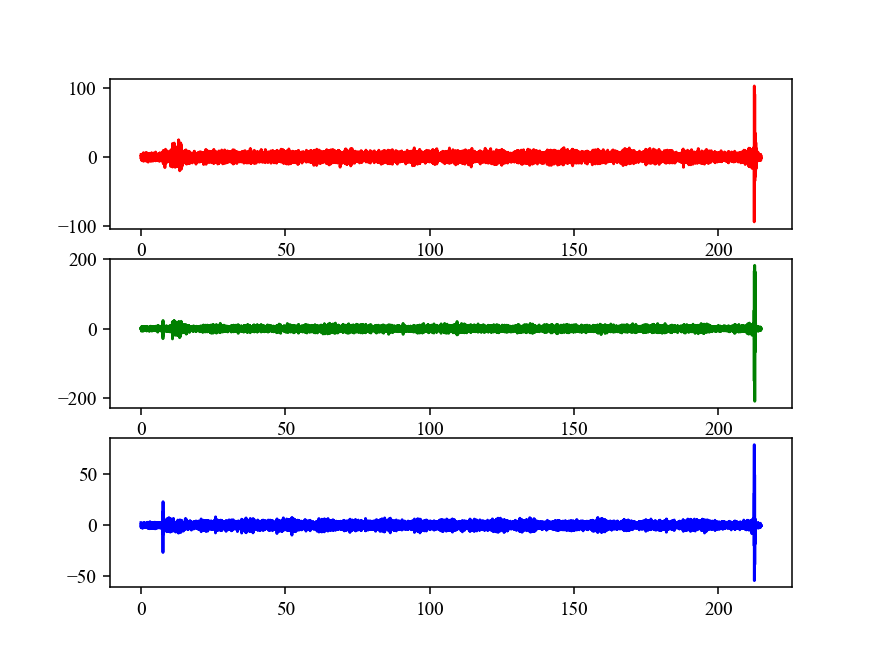

In [17]:
# Unexplained acceleration in the body frame
alpha_unexplained = omegadot_I_B - omegadot_transport_B

fig, ax = plt.subplots(3, 1)

ax[0].plot(t_q, alpha_unexplained[:,0], color='r')
ax[1].plot(t_q, alpha_unexplained[:,1], color='g')
ax[2].plot(t_q, alpha_unexplained[:,2], color='b')

plt.show()

## Examine proposed motor forces

Now that there is a vector of unexplained accelerations, time to import the motor rpms to estimate forces.

In [18]:
motor_rpms = test_df[['rpm1', 'rpm2', 'rpm3', 'rpm4']].dropna()
t_motors = (motor_rpms.index - test_df.index[0]).values * rbts2s
t_motors = t_motors.astype('float')
motor_rpms = motor_rpms.reset_index()

motor_rpms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38272 entries, 0 to 38271
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rosbagTimestamp  38272 non-null  int64  
 1   rpm1             38272 non-null  float64
 2   rpm2             38272 non-null  float64
 3   rpm3             38272 non-null  float64
 4   rpm4             38272 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.5 MB


<IPython.core.display.Javascript object>


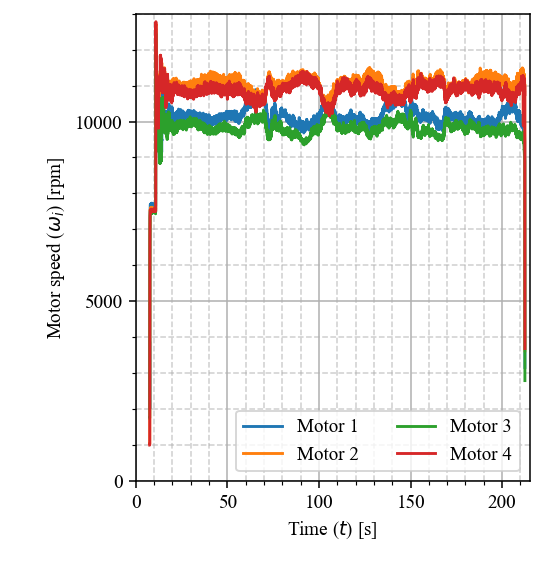

In [65]:
fig, ax = plt.subplots(1,1)

fig.set_size_inches(2.875,3)
ax.set_position([0.25, 0.15, 0.725, 0.825])

for i in range(4):
    ax.plot(t_motors, motor_rpms['rpm' + str(i+1)], label=('Motor %i' % (i+1)))

ax.set_xlabel('Time ($t$) [s]')
ax.set_ylabel('Motor speed ($\omega_{i}$) [rpm]')

ax.legend(ncol=2)

ax.set_xlim(0, 215)
ax.set_ylim(0, 13000)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5e3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e3))

ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle='--', alpha=0.6)

fig.savefig("../report/project-report/figures/methodology/motors-unscaled.png")

plt.show()

A quick comment is the motor rpms look noisy. A SG filter may work an also get omega dot 
which may be helpful in estimating time derivatives of inertia matrix

In [20]:
# Interpolating from the quaternions
def linear_interpolation(X, Y, x):
    """
    Summary: Linear interpolations on the series given by X, Y for the values in x to return y
    Inputs:
        * X = known input points in strictly increasing order (easy for time series)
        * Y = corresponding output points to X
    Outputs:
        * y = interpolated output values
    Notes:
        * only for 1D case currently
        * I could easily make this a Langrangian interpolation or taylor series from closest point
    """
    # initialize output
    y = np.zeros((x.shape[0], Y.shape[1])) # same number of x entries but same column width as Y
    
    # go through points for interpolation
    NX = X.shape[0]
    for i in range(x.shape[0]):
        xi = x[i]
        ind1 = np.argmin(np.abs(X - xi)) # index of closest element in X to xi
        # The argmin probably slows it down, could use a loop if x is ordered as well
        X1 = X[ind1]
        # Iterate through cases for second index variable
        if xi == X1:
            y[i] = Y[ind1]
            continue
        elif xi < X1:
            if ind1 != 0:
                ind2 = ind1 - 1 # interpolate
            else:
                ind2 = 1  # extrapolate
        else:
            if ind1 != NX - 1:
                ind2 = ind1 + 1  # interpolate
            else:
                ind2 = ind1 - 1 # extrapolate
        X2 = X[ind2]
        
        # Do the interpolation
        Y1 = Y[ind1]
        Y2 = Y[ind2]
        y[i] = Y1 + (xi - X1)*(Y2 - Y1)/(X2 - X1)

    # Return interpolated outputs
    return y

In [21]:
# Interpolate accelerations in quaternion time series to motor time series
a_unexplained_tM = linear_interpolation(t_q, a_unexplained, t_motors)
alpha_unexplained_tM = linear_interpolation(t_q, alpha_unexplained, t_motors)

<IPython.core.display.Javascript object>


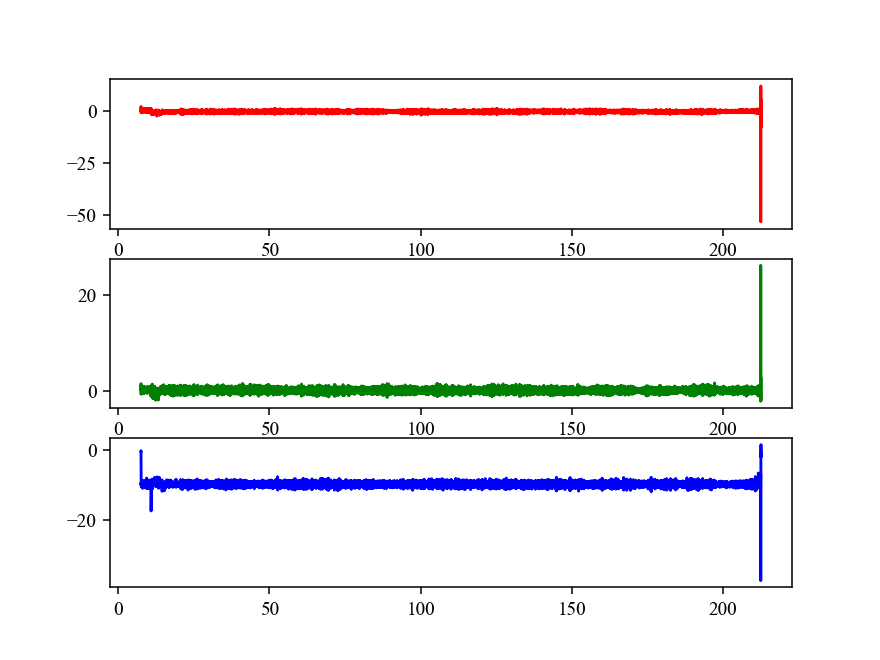

In [22]:
fig, ax = plt.subplots(3,1)

for i, c in zip(list(range(3)), ['r', 'g', 'b']):
    ax[i].plot(t_motors, a_unexplained_tM[:, i], color=c)

plt.show()

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# OLS only on z-body acceleration
X = motor_rpms[['rpm1', 'rpm2', 'rpm3', 'rpm4']].values
y = a_unexplained_tM[:,2] * vehicle.mass
print('Linear Model with intercept')
model = LinearRegression().fit(X, y)
print(model.coef_, model.intercept_)
print(model.score(X, y))

print('\nLinear Model without intercept')
model = LinearRegression(fit_intercept=False).fit(X, y)
print(model.coef_, model.intercept_)
print(model.score(X, y))

# Quadratic model w/ intercept
print('\nQuadratic model with intercept')
X2 = X ** 2
model = LinearRegression().fit(X2, y)
print(model.coef_, model.intercept_)
print(model.score(X2, y))
print(np.mean(model.coef_), vehicle.CT)

# Quadratic model w/o intercept
print('\nQuadratic model without intercept')
model = LinearRegression(fit_intercept=False).fit(X2, y)
print(model.coef_, model.intercept_)
print(model.score(X2, y))
print(np.mean(model.coef_), vehicle.CT)

# Full quadrtic
print('\nFull quadratic model')
poly = PolynomialFeatures(2)
Xpoly = poly.fit_transform(X)
model = LinearRegression(fit_intercept=False).fit(Xpoly, y)
print(model.coef_, model.intercept_)
print(model.score(Xpoly, y))

Linear Model with intercept
[-9.80982203e-06  1.64816257e-05 -1.46966336e-04 -3.42055018e-05] -7.2478088979532025
0.013461183474296924

Linear Model without intercept
[-1.28129470e-04  5.73648550e-05 -5.66739851e-04 -2.54513143e-04] 0.0
-0.21735504889764187

Quadratic model with intercept
[-1.59672534e-09  3.38495687e-10 -6.42316689e-09 -1.82963987e-09] -8.020897897557704
0.012396331938424045
-2.3777591023769494e-09 2.27e-08

Quadratic model without intercept
[-1.57005825e-08 -4.70775723e-09 -4.39385572e-08 -2.17538032e-08] 0.0
-0.8285391695268878
-2.1525175025491412e-08 2.27e-08

Full quadratic model
[-8.63919920e+00  3.56396125e-03 -1.96196307e-02 -9.77868224e-03
  2.59603730e-02  4.13331692e-07 -4.18336658e-07 -3.67571237e-07
 -3.57883460e-07  5.10199105e-09  2.46708998e-06 -5.08654695e-08
 -1.94438645e-09 -1.27079325e-06 -4.38305998e-07] 0.0
0.06215571268307929


Some of the average thrust coefficients are at least somewhat close to the reported value but there is still about a 10 percent discrepency. It looks like z accelerations alone won't allow for accurate thrust coefficient estimations. I'll try adding in X and Y body axis moments.

<IPython.core.display.Javascript object>


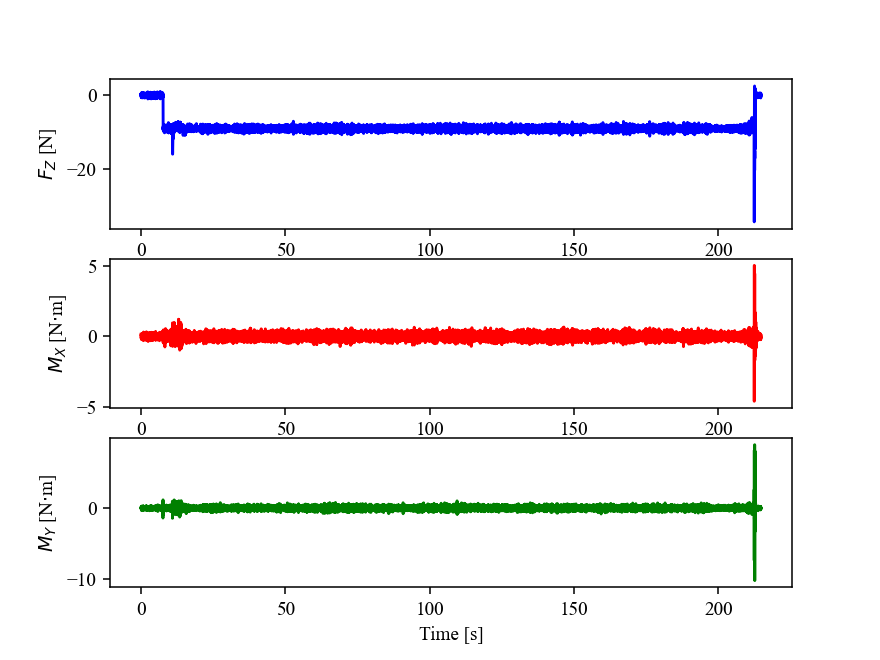

In [24]:
# Generating multipliers for rpms for Z-body force and X, Y body momements
Z_f_coeff = -1.*np.ones(X.shape)

X_m_coeff = np.ones(X.shape) # Initial matrix
X_m_coeff[:, [1, 2]] = -1. # motors 1, 4 positive, 2, 3 are negative
X_m_coeff = X_m_coeff*vehicle.l*np.cos(vehicle.arm_angle_from_xbody)

Y_m_coeff = np.ones(X.shape)
Y_m_coeff[:, [2, 3]] = -1. # motors 1, 2 positive, 3, 4 are negative
Y_m_coeff = Y_m_coeff*vehicle.l*np.sin(vehicle.arm_angle_from_xbody)

# Calculating forces and moments from motor force (In quaternion time scale for now)
F_Z_B = a_unexplained[:, 2]*vehicle.mass
M_X_B = alpha_unexplained[:, 0]*vehicle.Ixx
M_Y_B = alpha_unexplained[:, 1]*vehicle.Iyy

fig, ax = plt.subplots(3,1)

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')

ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

In [25]:
# setting up output variable y

# Need an Nx1 vector not a N list
F_Z_B = F_Z_B.reshape((t_q.shape[0],1))
M_X_B = M_X_B.reshape((t_q.shape[0],1))
M_Y_B = M_Y_B.reshape((t_q.shape[0],1))

# Interpolating into motor time
t1 = time.time()
F_Z_B_tM = linear_interpolation(t_q, F_Z_B, t_motors)
M_X_B_tM = linear_interpolation(t_q, M_X_B, t_motors)
M_Y_B_tM = linear_interpolation(t_q, M_Y_B, t_motors)
print('Time to interpolate Nx1 vector 3 times: %f' % (time.time() - t1))

# Interpolating into motor time
t1 = time.time()
y = linear_interpolation(t_q, np.concatenate((F_Z_B, M_X_B, M_Y_B), axis=1), t_motors)
"""
F_Z_B_tM = y[:, 0]
M_X_B_tM = y[:, 1]
M_Y_B_tM = y[:, 2]
"""
print('Time to interpolate Nx1 1 time: %f' % (time.time() - t1))

# Concatenating into y vector
#y = np.concatenate((F_Z_B_tM, M_X_B_tM, M_Y_B_tM), axis=0)
y = y.flatten('F') # column style flattining -> [Fz^T, Mx^T, My^T]^T
y = y.reshape((y.shape[0], 1))
print(y)

Time to interpolate Nx1 vector 3 times: 82.190708
Time to interpolate Nx1 1 time: 27.656053
[[-0.34611237]
 [-0.2998899 ]
 [-8.9451944 ]
 ...
 [ 1.13258837]
 [ 1.20996874]
 [ 0.52914055]]


In [26]:
# Setting up regression matrix
rpm2 = motor_rpms[['rpm1', 'rpm2', 'rpm3', 'rpm4']].values ** 2
Xreg = np.concatenate((Z_f_coeff*rpm2, X_m_coeff*rpm2, Y_m_coeff*rpm2), axis=0)
print(Xreg)

[[-14992128.76671129  -1065996.76108384  -3065667.13921608
    -997737.12144905]
 [-14992128.76671129  -1065996.76108384  -3065667.13921608
    -997737.12144905]
 [ -3996801.90902354 -15705463.8180142  -21029134.41041207
  -16172042.03739762]
 ...
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]
 [   897979.53707545   1180618.86222853   -702159.87517582
   -1222464.35190795]]


In [27]:
# Trying regression
model = LinearRegression(fit_intercept=False).fit(Xreg, y)
print(model.coef_, model.intercept_)
print(np.mean(model.coef_))
print("Cumulative R^2: %f" % model.score(Xreg, y))
print("F_Z R^2: %f" % model.score(Z_f_coeff*rpm2, y[:int(y.shape[0]/3)]))
print("M_X R^2: %f" % model.score(X_m_coeff*rpm2, y[int(y.shape[0]/3):int(2*y.shape[0]/3)]))
print("M_Y R^2: %f" % model.score(Y_m_coeff*rpm2, y[int(2*y.shape[0]/3):]))

[[2.75583103e-08 1.32541638e-08 3.00361633e-08 1.39409146e-08]] 0.0
2.1197388001793426e-08
Cumulative R^2: 0.987939
F_Z R^2: -0.838156
M_X R^2: 0.027115
M_Y R^2: 0.020779


In [28]:
yp = model.predict(Xreg)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')
print(yp)

[[-0.53327688  0.02887716  0.02891667]
 [-0.53327688  0.02887716  0.02891667]
 [-1.17539547 -0.04537792 -0.04849017]
 ...
 [-0.87252638  0.00505077  0.00226245]
 [-0.87252638  0.00505077  0.00226245]
 [-0.87252638  0.00505077  0.00226245]]


<IPython.core.display.Javascript object>


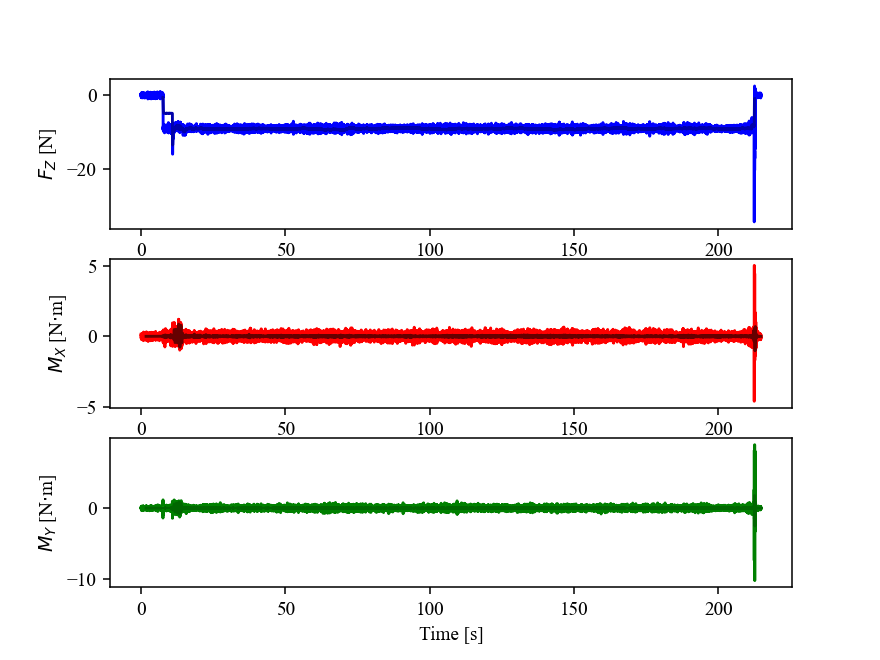

In [29]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')

ax[1].plot(t_imu, omegadot_gyro[:,0]*vehicle.Ixx, color='#660000')
ax[2].plot(t_imu, omegadot_gyro[:,1]*vehicle.Iyy, color='#006600')

ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

In [30]:
N_imu = omegadot_gyro.shape[0]
N_motor = t_motors.shape[0]
M_X_B_imu = (omegadot_gyro[:,0]*vehicle.Ixx).reshape((N_imu, 1))
M_Y_B_imu = (omegadot_gyro[:,1]*vehicle.Ixx).reshape((N_imu, 1))

M_B = linear_interpolation(t_imu, np.concatenate((M_X_B_imu, M_Y_B_imu), axis=1), t_motors).flatten('F')
y = np.concatenate((F_Z_B_tM, M_B.reshape((2*N_motor, 1))))
print(y)

[[-0.34611237]
 [-0.2998899 ]
 [-8.9451944 ]
 ...
 [ 1.31303754]
 [ 1.48623954]
 [ 1.62293127]]


In [31]:
# Trying regression
model = LinearRegression(fit_intercept=False).fit(Xreg, y)
print(model.coef_, model.intercept_)
print(np.mean(model.coef_))
print("Cumulative R^2: %f" % model.score(Xreg, y))
print("F_Z R^2: %f" % model.score(Z_f_coeff*rpm2, y[:int(y.shape[0]/3)]))
print("M_X R^2: %f" % model.score(X_m_coeff*rpm2, y[int(y.shape[0]/3):int(2*y.shape[0]/3)]))
print("M_Y R^2: %f" % model.score(Y_m_coeff*rpm2, y[int(2*y.shape[0]/3):]))

[[2.76020012e-08 1.32588548e-08 3.00677595e-08 1.38717620e-08]] 0.0
2.120009435920752e-08
Cumulative R^2: 0.989380
F_Z R^2: -0.838189
M_X R^2: 0.173061
M_Y R^2: 0.168959


In [32]:
yp = model.predict(Xreg)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')
print(yp)

[[-0.53396477  0.02892073  0.02897357]
 [-0.53396477  0.02892073  0.02897357]
 [-1.17518987 -0.04552929 -0.04842697]
 ...
 [-0.87233106  0.00497774  0.00236958]
 [-0.87233106  0.00497774  0.00236958]
 [-0.87233106  0.00497774  0.00236958]]


<IPython.core.display.Javascript object>


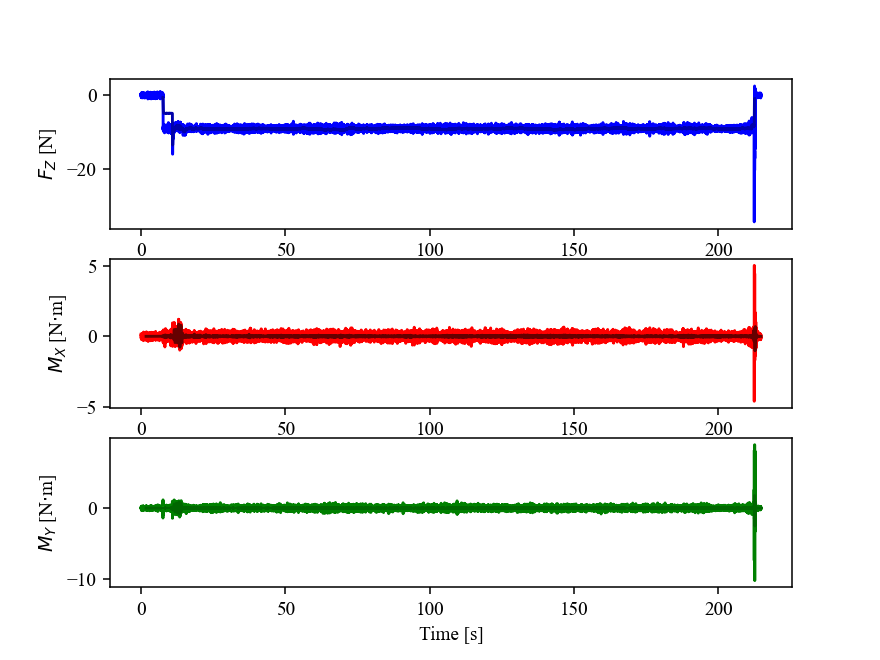

In [33]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')

ax[1].plot(t_imu, omegadot_gyro[:,0]*vehicle.Ixx, color='#660000')
ax[2].plot(t_imu, omegadot_gyro[:,1]*vehicle.Iyy, color='#006600')

ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

<IPython.core.display.Javascript object>


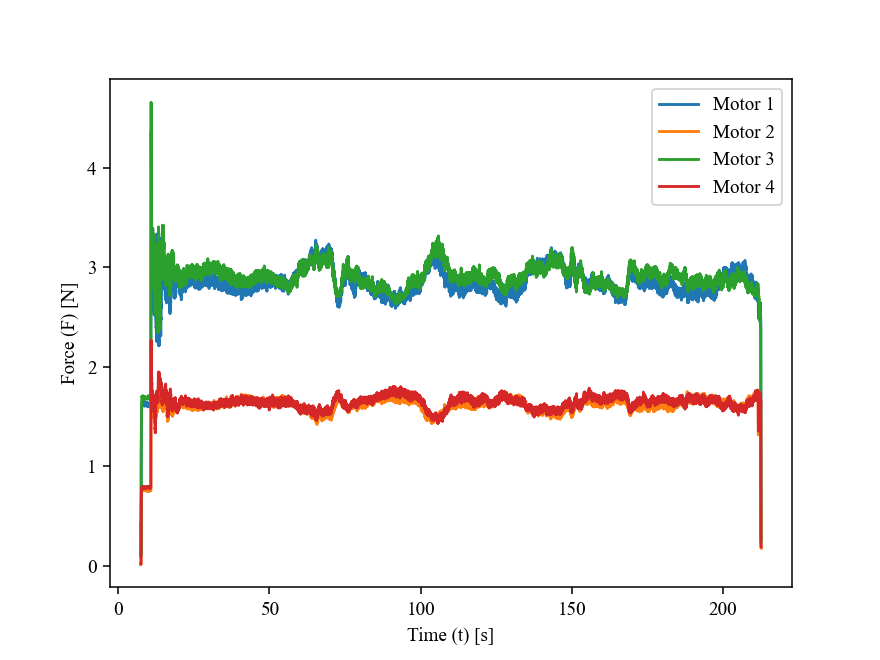

In [34]:
# verifying the forces
fig, ax = plt.subplots(1,1)

for i in range(1,5):
    ax.plot(t_motors, model.coef_[0, i-1]*motor_rpms['rpm%i' % i].values ** 2, label=('Motor %i' % i))

ax.set_xlabel('Time (t) [s]')
ax.set_ylabel('Force (F) [N]')
ax.legend()
plt.show()

The mean motor coefficient is still about 10 percent off so I'll try using a single coefficient if that works better.

In [35]:
# Trying with just a single coefficient
Xreg_single_col = np.sum(np.concatenate((Z_f_coeff*rpm2, X_m_coeff*rpm2, Y_m_coeff*rpm2), axis=0),
                          axis=1).reshape((Xreg.shape[0],1))
model = LinearRegression(fit_intercept=False).fit(Xreg_single_col, y)
print(model.coef_, model.intercept_)

# Prediction for plotting
yp = model.predict(Xreg_single_col)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')

[[2.04782521e-08]] 0.0


<IPython.core.display.Javascript object>


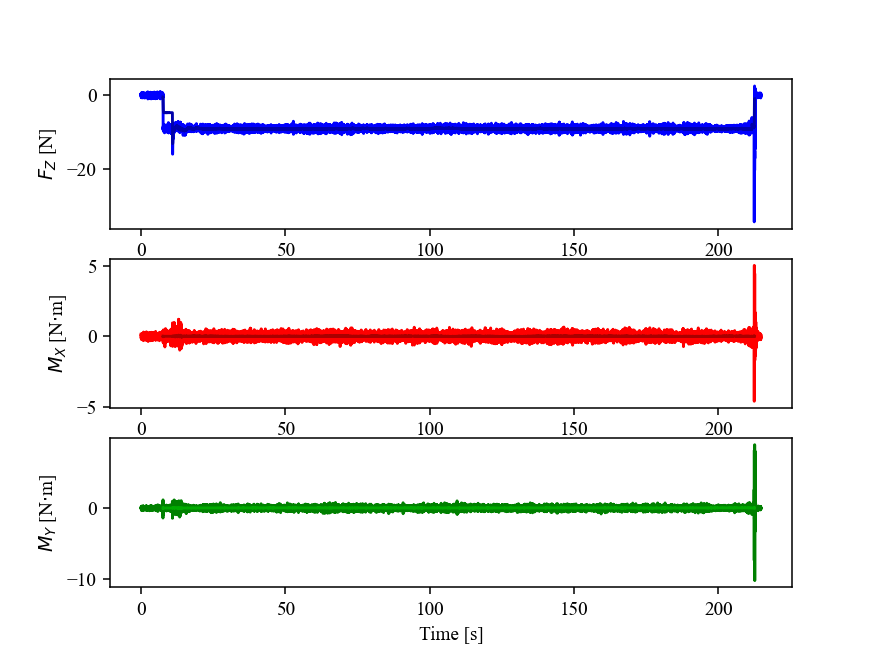

In [36]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

<IPython.core.display.Javascript object>


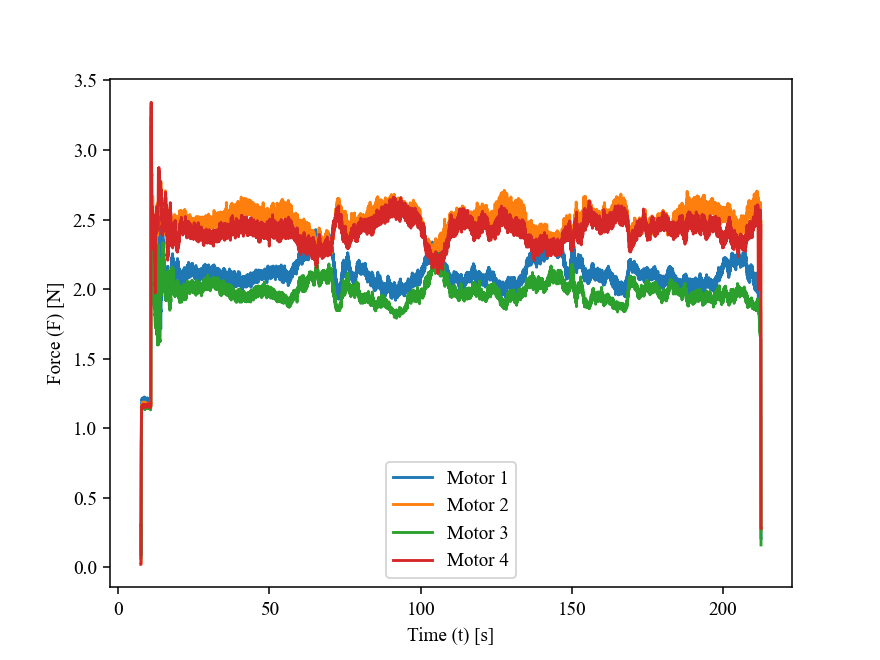

In [37]:
# verifying the forces
fig, ax = plt.subplots(1,1)

for i in range(1,5):
    ax.plot(t_motors, model.coef_[0, 0]*motor_rpms['rpm%i' % i].values ** 2, label=('Motor %i' % i))

ax.set_xlabel('Time (t) [s]')
ax.set_ylabel('Force (F) [N]')
ax.legend()
plt.show()

The discrepancies of the forces still seem to be to far off to be valid. I'll look at the yawing moment to try and get a determination of an average torque coefficient ($C_Q$)

In [38]:
def continuous_yaw(yaw_vec):
    """Correction for modularity"""
    for i in range(1, yaw_vec.shape[0]):
        dpsi = yaw_vec[i] - yaw_vec[i-1]
        if dpsi > np.pi:
            yaw_vec[i:] = yaw_vec[i:] - 2*pi
        elif dpsi < np.pi:
            yaw_vec[i:] = yaw_vec[i:] + 2*pi
    return yaw_vec

<IPython.core.display.Javascript object>


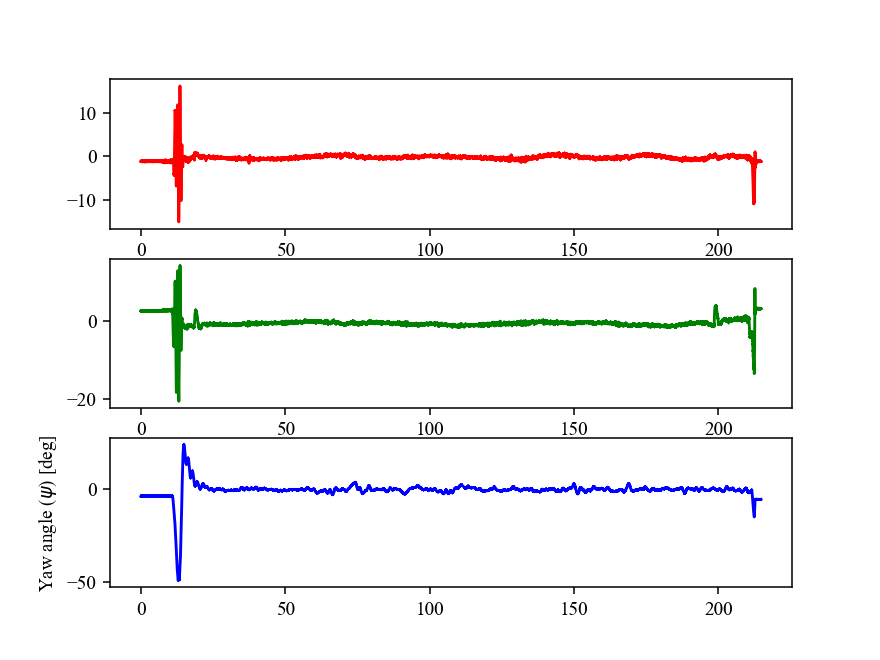

In [39]:
t_angles = test_df['roll_[rad]'].dropna().index
t_angles = (t_angles - test_df.index[0])*rbts2s
t_angles = t_angles.astype('float')

fig, ax = plt.subplots(3,1)

ax[0].plot(t_angles, 180./np.pi*test_df['roll_[rad]'].dropna(), color='r')
ax[1].plot(t_angles, 180./np.pi*test_df['pitch_[rad]'].dropna(), color='g')
ax[2].plot(t_angles, 180./np.pi*test_df['yaw_[rad]'].dropna(), color='b')
ax[2].set_ylabel('Yaw angle ($\psi$) [deg]')

plt.show()

In [40]:
M_Z_B = alpha_unexplained[:, 2]*vehicle.Izz
M_Z_B = M_Z_B.reshape((M_Z_B.shape[0], 1))
M_Z_B_tM = linear_interpolation(t_q, M_Z_B, t_motors)

In [41]:
model = LinearRegression(fit_intercept=False).fit(rpm2, M_Z_B_tM)
print(model.coef_)
print(np.mean(np.abs(model.coef_)))
print(model.score(rpm2, M_Z_B_tM))

M_Z_B_p = model.predict(rpm2)

[[-3.14454207e-10  4.61737163e-10 -2.02063729e-10 -4.24173749e-11]]
2.551681183381607e-10
0.0005982042033925161


<IPython.core.display.Javascript object>


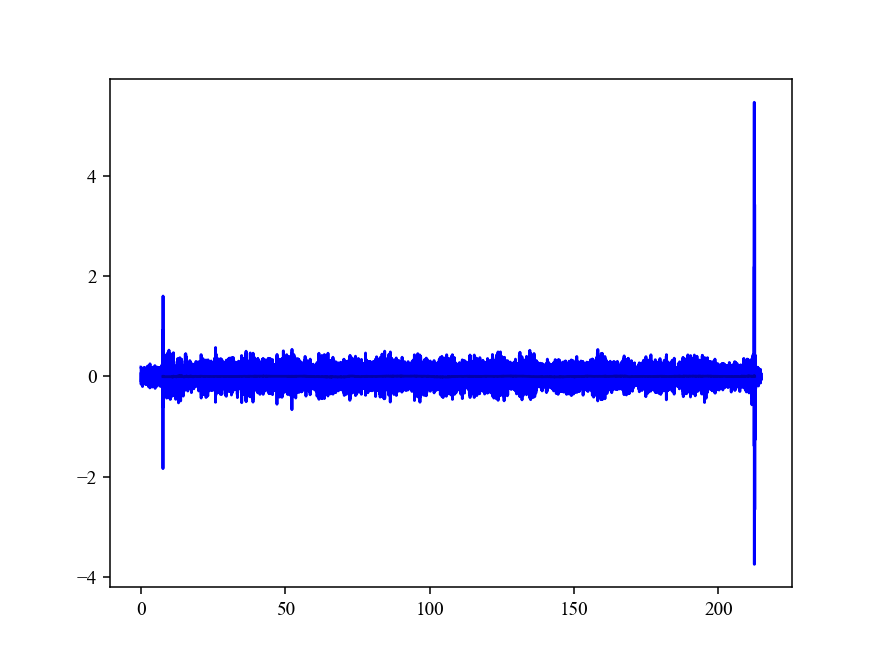

In [42]:
fig, ax = plt.subplots(1,1)

ax.plot(t_q, M_Z_B, color='b')
ax.plot(t_motors, M_Z_B_p, color='#0000aa')

plt.show()

[[-6.54149158e-10 -2.34025750e-10  4.26747840e-11  7.78498179e-10]]
4.273369678127822e-10
0.05474799176874723


<IPython.core.display.Javascript object>


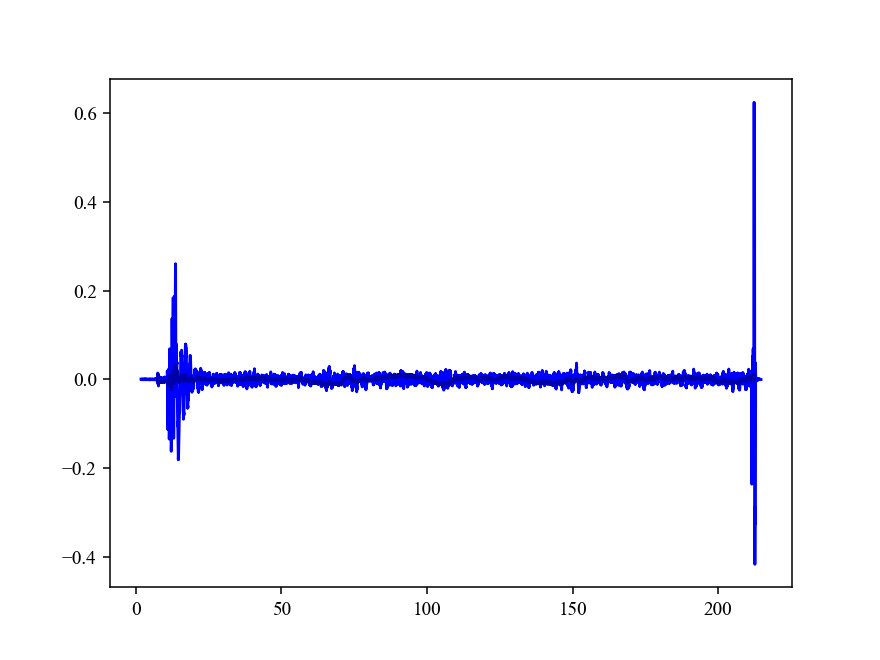

In [43]:
# Same as above but trying IMU values
M_Z_B = omegadot_gyro[:, 2]*vehicle.Izz
M_Z_B = M_Z_B.reshape((M_Z_B.shape[0], 1))
M_Z_B_tM = linear_interpolation(t_imu, M_Z_B, t_motors)
model = LinearRegression(fit_intercept=False).fit(rpm2, M_Z_B_tM)
print(model.coef_)
print(np.mean(np.abs(model.coef_)))
print(model.score(rpm2, M_Z_B_tM))

M_Z_B_p = model.predict(rpm2)

fig, ax = plt.subplots(1,1)

ax.plot(t_imu, M_Z_B, color='b')
ax.plot(t_motors, M_Z_B_p, color='#0000aa')

plt.show()

In [44]:
# Trying to get estimates of signed values
model = LinearRegression(fit_intercept=False).fit(np.abs(X_m_coeff)*rpm2, M_X_B_tM)
print(model.coef_)
model = LinearRegression(fit_intercept=False).fit(np.abs(Y_m_coeff)*rpm2, M_Y_B_tM)
print(model.coef_)

[[ 1.36109533e-07 -1.25780251e-07 -1.52495418e-07  1.35471682e-07]]
[[ 1.31591035e-07  1.39915546e-07 -1.49027928e-07 -1.37570762e-07]]


In [45]:
# Trying to determine the handedness in the data
model = LinearRegression(fit_intercept=False).fit(np.matmul(rpm2, np.array([[-1, 1, -1, 1]]).T), M_Z_B_tM)
print(model.coef_)

[[3.92141072e-11]]


### Scaling RPMs

I'm  just going to go with assume that the motor RPM sensors have a scale factor error and see if scaling all the motor RPMs to the median works well.

In [46]:
rpm = motor_rpms[['rpm1', 'rpm2', 'rpm3', 'rpm4']].values
print(np.median(rpm, axis=0))

[10123.16503906 11066.02734375  9808.72949219 10891.26855469]


In [47]:
# Do the scaling
rpm_med = np.median(rpm, axis=0)
mmed_rpm = np.median(rpm_med)
new_rpm = rpm.copy()
for i in range(new_rpm.shape[1]):
    new_rpm[:, i] = new_rpm[:, i]*mmed_rpm/rpm_med[i]

<IPython.core.display.Javascript object>


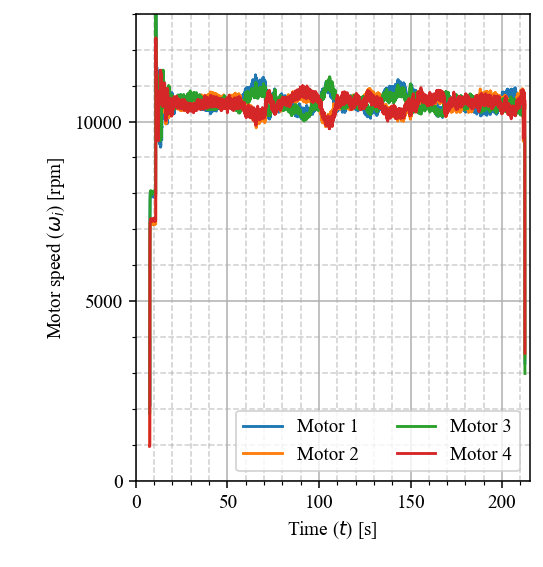

In [64]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(2.875,3)
ax.set_position([0.25, 0.15, 0.725, 0.825])

for i in range(new_rpm.shape[1]):
    ax.plot(t_motors, new_rpm[:, i], label="Motor %i" % (i+1))

ax.legend(ncol=2)
ax.set_ylabel('Motor speed ($\omega_i$) [rpm]')
ax.set_xlabel('Time ($t$) [s]')

ax.set_xlim(0, 215)
ax.set_ylim(0, 13000)

ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5e3))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1e3))

ax.grid(True, which='major')
ax.grid(True, which='minor', linestyle='--', alpha=0.6)

fig.savefig("../report/project-report/figures/methodology/motors-scaled.png")

plt.show()

In [49]:
# Trying with individual coefficientx
new_rpm2 = new_rpm **2
Xreg = np.concatenate((Z_f_coeff*new_rpm2, X_m_coeff*new_rpm2, Y_m_coeff*new_rpm2), axis=0)
model = LinearRegression(fit_intercept=False).fit(Xreg, y)
print(model.coef_, model.intercept_)

# Prediction for plotting
yp = model.predict(Xreg)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')

[[2.56211027e-08 1.47066618e-08 2.62030109e-08 1.49043546e-08]] 0.0


<IPython.core.display.Javascript object>


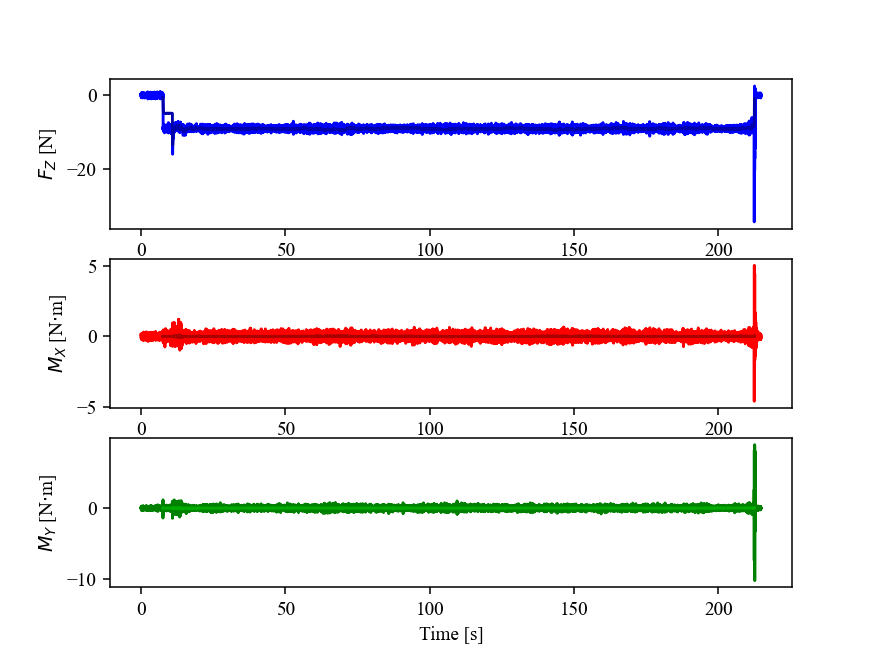

In [50]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

C:\Users\Patrick\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


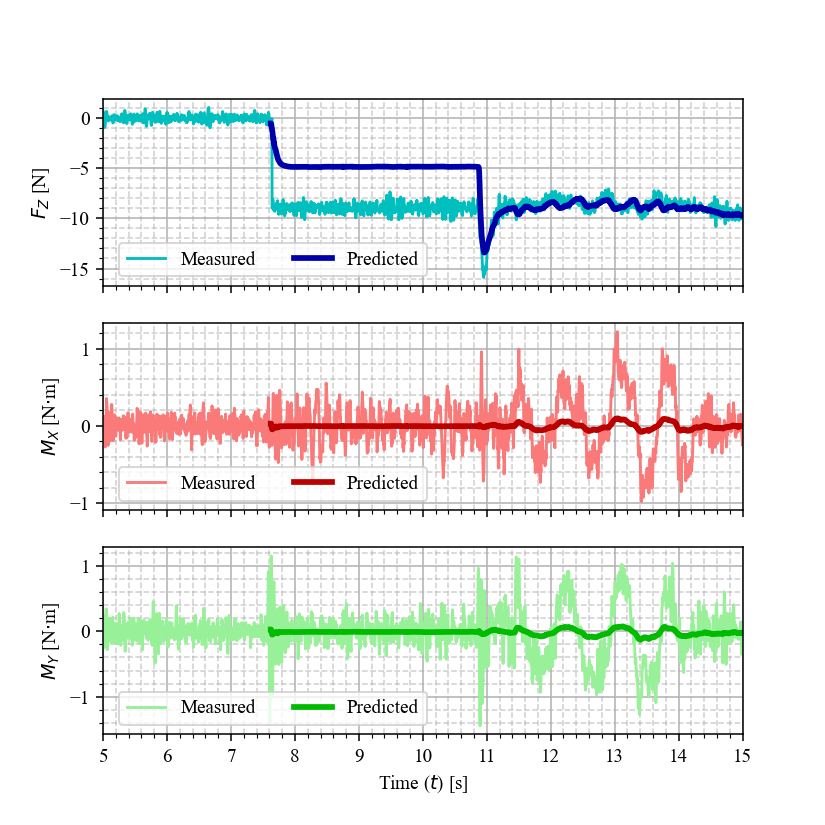

In [51]:
fig, ax = plt.subplots(3,1, sharex=True)
fig.set_size_inches(6,6)

d2r = np.pi/180.

qind = np.logical_and(t_q >= 5., t_q <= 15.)
mind = np.logical_and(t_motors >= 5., t_motors <= 15.)

ax[0].set_xlim(5, 15)
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
ax[0].xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

# Plotting
ax[0].plot(t_q[qind], F_Z_B[qind], color='c', label="Measured")
ax[1].plot(t_q[qind], M_X_B[qind], color='#FA7A7A', label="Measured")
ax[2].plot(t_q[qind], M_Y_B[qind], color='#98F098', label="Measured")


ax[0].plot(t_motors[mind], yp[mind,0], color='#0000aa', linewidth=3, zorder=2, label="Predicted")
ax[1].plot(t_motors[mind], yp[mind,1], color='#bb0000', linewidth=3, zorder=2, label="Predicted")
ax[2].plot(t_motors[mind], yp[mind,2], color='#00bb00', linewidth=3, zorder=2, label="Predicted")

ax[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[1].yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

ax[2].yaxis.set_major_locator(ticker.MultipleLocator(1))
ax[2].yaxis.set_minor_locator(ticker.MultipleLocator(0.2))

for a in ax:
    a.grid(True, which='major')
    a.grid(True, which='minor', linestyle='--', alpha=0.6)
    a.legend(
        loc=(0.025, 0.05),
        ncol=2
    )


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time ($t$) [s]')

fig.savefig("../report/project-report/figures/pow/motor-model-results.png")

plt.show()

In [52]:
# Trying with just a single coefficient
new_rpm2 = new_rpm **2
Xreg_single_col = np.sum(np.concatenate((Z_f_coeff*new_rpm2, X_m_coeff*new_rpm2, Y_m_coeff*new_rpm2), axis=0),
                          axis=1).reshape((Xreg.shape[0],1))
model = LinearRegression(fit_intercept=False).fit(Xreg_single_col, y)
print(model.coef_, model.intercept_)

# Prediction for plotting
yp = model.predict(Xreg_single_col)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')

[[2.0384986e-08]] 0.0


<IPython.core.display.Javascript object>


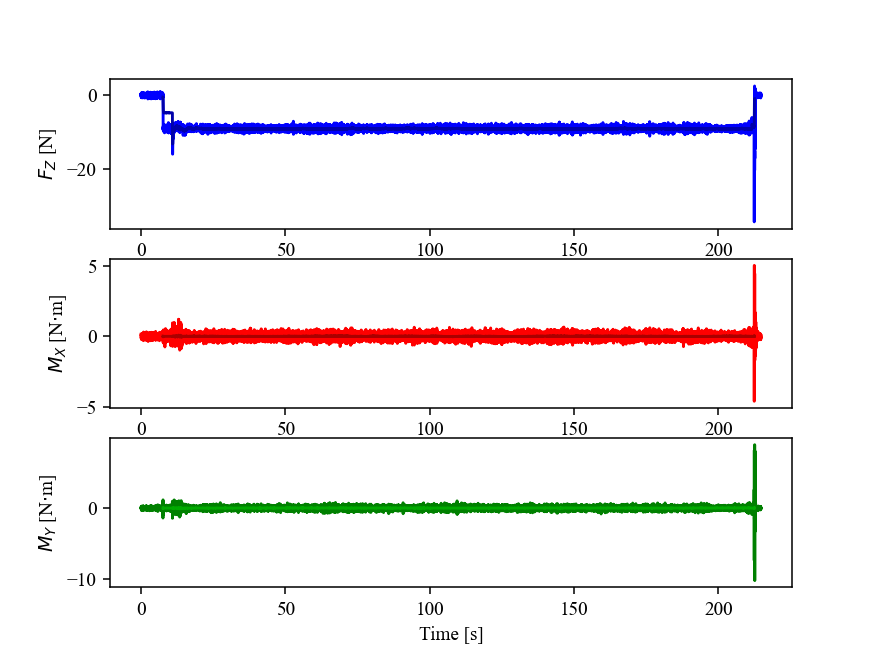

In [53]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

In [54]:
M_B = linear_interpolation(t_imu, np.concatenate((M_X_B_imu, M_Y_B_imu), axis=1), t_motors).flatten('F')
y = np.concatenate((F_Z_B_tM, M_B.reshape((2*N_motor, 1))))
model = LinearRegression(fit_intercept=False).fit(Xreg_single_col, y)
print(model.coef_, model.intercept_)

# Prediction for plotting
yp = model.predict(Xreg_single_col)
yp = yp.reshape((int(yp.shape[0]/3), 3), order='F')

[[2.0384986e-08]] 0.0


<IPython.core.display.Javascript object>


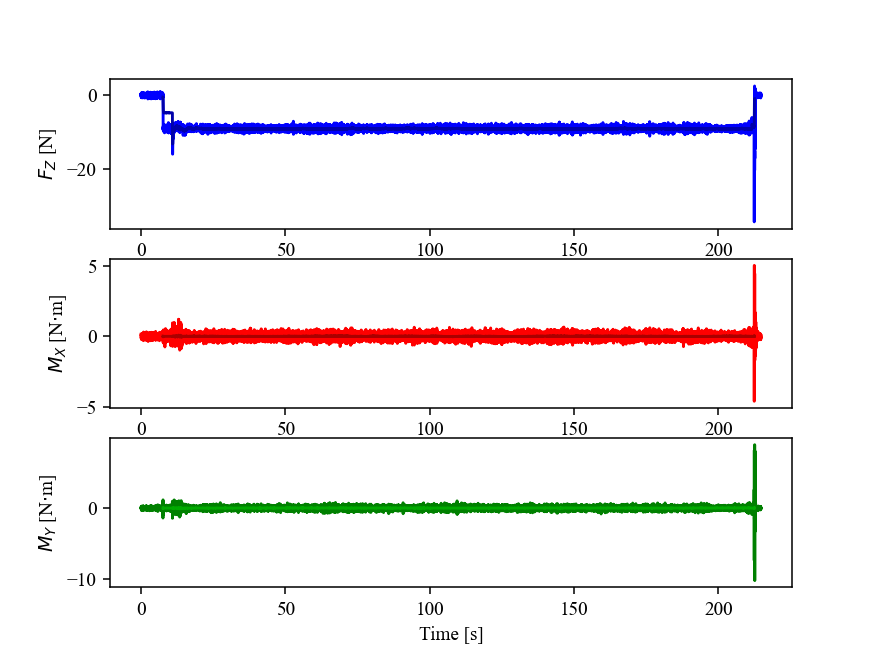

In [55]:
fig, ax = plt.subplots(3,1)

d2r = np.pi/180.

# Plotting
ax[0].plot(t_q, F_Z_B, color='b')
ax[1].plot(t_q, M_X_B, color='r')
ax[2].plot(t_q, M_Y_B, color='g')


ax[0].plot(t_motors, yp[:,0], color='#0000aa')
ax[1].plot(t_motors, yp[:,1], color='#aa0000')
ax[2].plot(t_motors, yp[:,2], color='#00aa00')


ax[0].set_ylabel('$F_Z$ [N]')
ax[1].set_ylabel('$M_X$ [N$\cdot$m]')
ax[2].set_ylabel('$M_Y$ [N$\cdot$m]')
ax[2].set_xlabel('Time [s]')

plt.show()

## Filterings

The filtering is to try and improve the quality of the fits. The motor angular speeds will be put through a fairly low order Savitzky-Golatz just to try and also get derivative angular speed terms. Also work on implementing adaptive timestep low pass filters for the various signals.

In [56]:
# SG filter here for motors

rpm_est = np.zeros(new_rpm.shape)
rpmdot_est = np.zeros(new_rpm.shape)

t1 = time.time()
for i in range(4):
    motor_est = dsp.central_sg_filter(t_motors, new_rpm[:,i], m=3, window=51)
    rpm_est[:,i] = motor_est[:,0]
    rpmdot_est[:,i] = motor_est[:,1]
    print("Motor %i: %f" % (i, time.time() - t1))

Motor 0: 3.739704
Motor 1: 7.573255
Motor 2: 11.289367
Motor 3: 15.028599


<IPython.core.display.Javascript object>


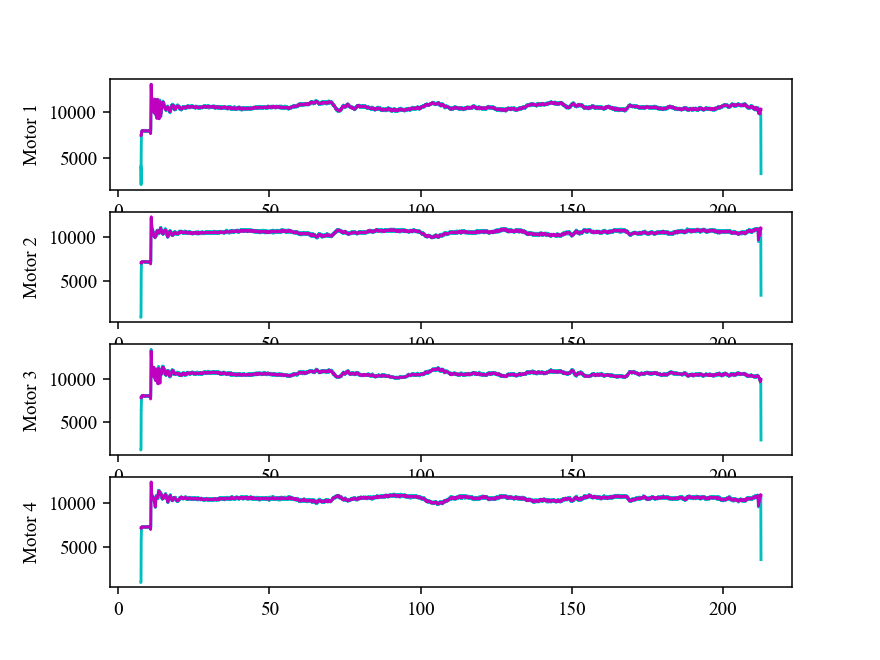

In [57]:
fig, ax = plt.subplots(4,1)

for i in range(4):
    ax[i].plot(t_motors, new_rpm[:, i], color='c')
    ax[i].plot(t_motors, rpm_est[:, i], color='m')
    #ax[i,1].plot(t_motors, rpmdot_est[:, i])
    ax[i].set_ylabel("Motor %i" % (i+1))
    
plt.show()

<IPython.core.display.Javascript object>


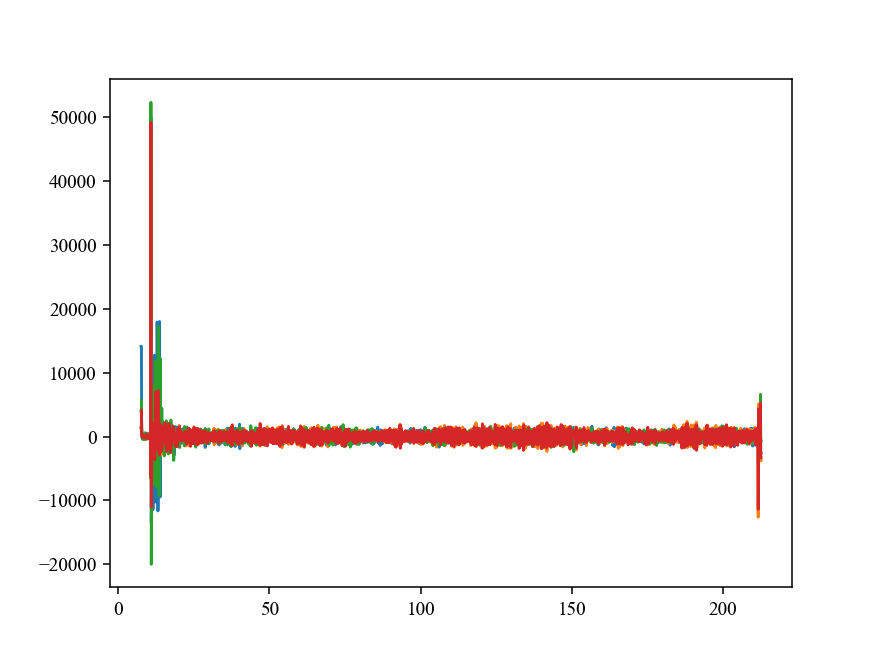

In [58]:
fig, ax = plt.subplots(1,1)

for i in range(4):
    ax.plot(t_motors, rpmdot_est[:, i], label=("Motor %i" % (i+1)))

plt.show()

In [59]:
def adaptive_low_pass(t, x, fc):
    """Adaptive timestep low pass filter
    
    Inputs:
        t = N time series vector
        x = NxM state vector
        fc = cut-off frequency
    
    Outputs:
        y = NxM smoothed state vector
    """
    # Preallocate output vector
    y = np.zeros(x.shape)
    # Cut off angular rate
    omega_c = 2.*np.pi*fc
    # Time step vector
    dt = np.zeros(t.shape)
    dt[1:] = t[1:] - t[:-1]
    # Calculate the weights
    alpha = omega_c*dt/(omega_c*dt + 1)
    # Iterate through time
    for i in range(t.shape[0]):
        if i == 0:
            # first point case
            y[0] = x[0]
        else:
            y[i] = (1 - alpha[i])*y[i-1] + alpha[i]*x[i]
    return y

<IPython.core.display.Javascript object>


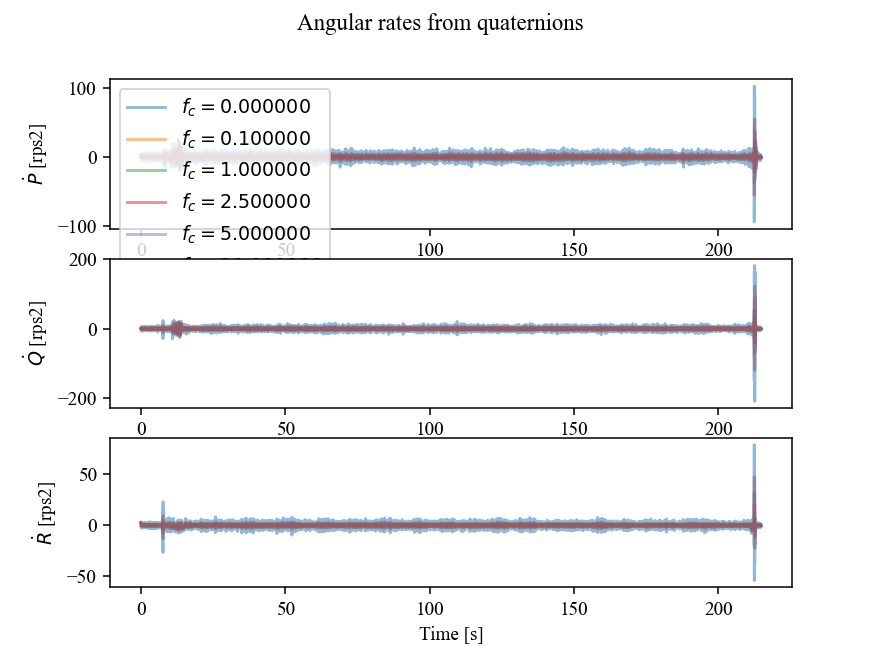

In [60]:
# Putting angular rates through a low pass

fig, ax = plt.subplots(3,1)

for fc in [0.,0.1, 1., 2.5, 5., 10.]:
    if fc == 0.:
        alpha_lp = alpha_unexplained
    else:
        alpha_lp = adaptive_low_pass(t_q, alpha_unexplained, fc)
    ax[0].plot(t_q, alpha_lp[:,0], alpha=0.5, label="$f_c = %f$" % fc)
    ax[1].plot(t_q, alpha_lp[:,1], alpha=0.5)
    ax[2].plot(t_q, alpha_lp[:,2], alpha=0.5)

fig.suptitle("Angular rates from quaternions")
ax[0].legend()
ax[0].set_ylabel('$\dot{P}$ [rps2]')
ax[1].set_ylabel('$\dot{Q}$ [rps2]')
ax[2].set_ylabel('$\dot{R}$ [rps2]')
ax[2].set_xlabel('Time [s]')

plt.show()

<IPython.core.display.Javascript object>


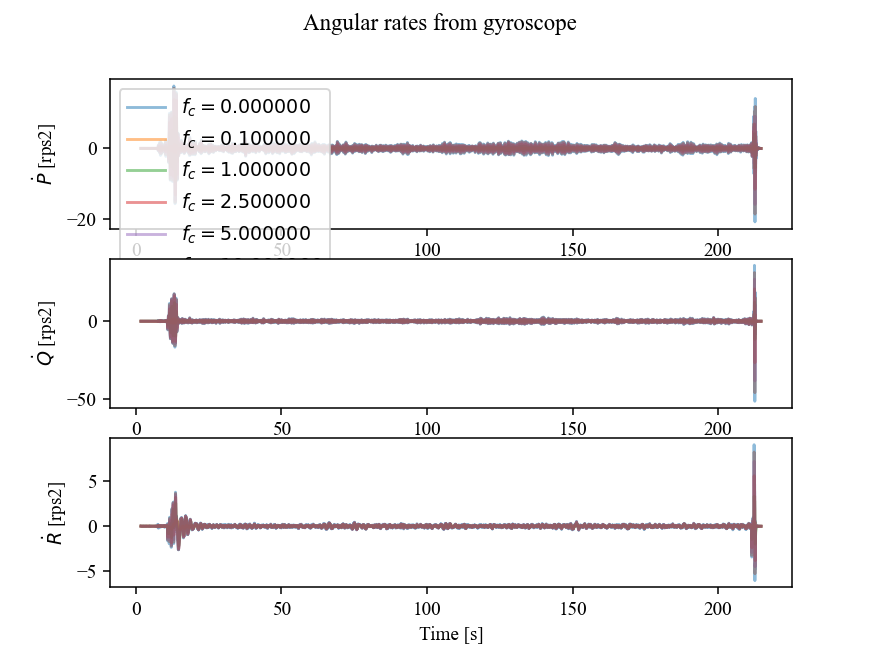

In [61]:
# Putting angular rates through a low pass

fig, ax = plt.subplots(3,1)

for fc in [0.,0.1, 1., 2.5, 5., 10.]:
    if fc == 0.:
        omegadot_lp = omegadot_gyro
    else:
        omegadot_lp = adaptive_low_pass(t_imu, omegadot_gyro, fc)
    ax[0].plot(t_imu, omegadot_lp[:,0], alpha=0.5, label="$f_c = %f$" % fc)
    ax[1].plot(t_imu, omegadot_lp[:,1], alpha=0.5)
    ax[2].plot(t_imu, omegadot_lp[:,2], alpha=0.5)

    
fig.suptitle("Angular rates from gyroscope")
ax[0].legend()
ax[0].set_ylabel('$\dot{P}$ [rps2]')
ax[1].set_ylabel('$\dot{Q}$ [rps2]')
ax[2].set_ylabel('$\dot{R}$ [rps2]')
ax[2].set_xlabel('Time [s]')

plt.show()

<IPython.core.display.Javascript object>


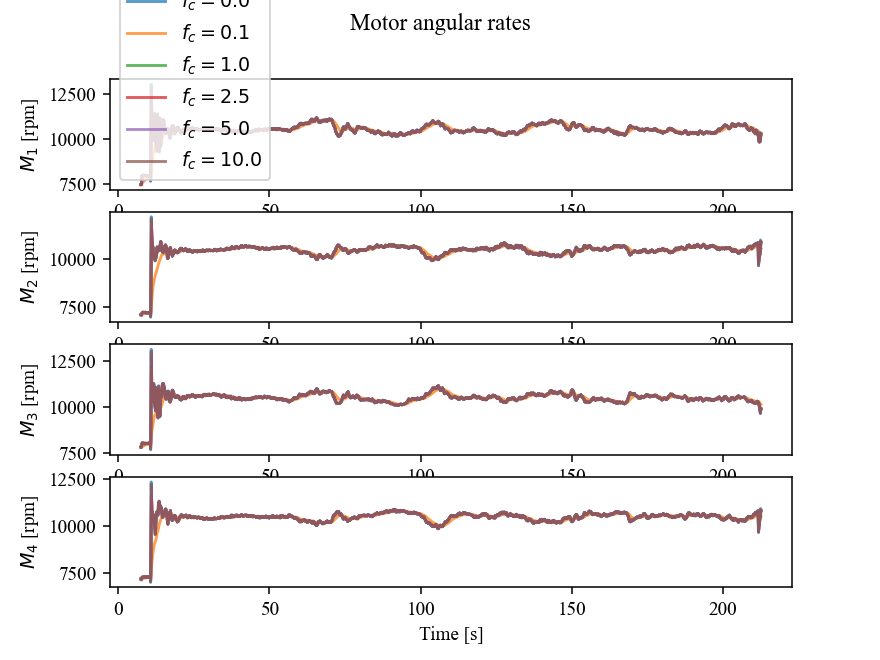

In [62]:
# Putting angular rates through a low pass
fig, ax = plt.subplots(4,1)

for fc in [0.,0.1, 1., 2.5, 5., 10.]:
    if fc == 0.:
        rpm_lp = rpm_est
    else:
        rpm_lp = adaptive_low_pass(t_motors, rpm_est, fc)
    ax[0].plot(t_motors, rpm_lp[:,0], alpha=0.75, label="$f_c = %.1f$" % fc)
    ax[1].plot(t_motors, rpm_lp[:,1], alpha=0.75)
    ax[2].plot(t_motors, rpm_lp[:,2], alpha=0.75)
    ax[3].plot(t_motors, rpm_lp[:,3], alpha=0.75)

    
fig.suptitle("Motor angular rates")
ax[0].legend()
ax[0].set_ylabel('$M_1$ [rpm]')
ax[1].set_ylabel('$M_2$ [rpm]')
ax[2].set_ylabel('$M_3$ [rpm]')
ax[3].set_ylabel('$M_4$ [rpm]')
ax[-1].set_xlabel('Time [s]')

plt.show()

<IPython.core.display.Javascript object>


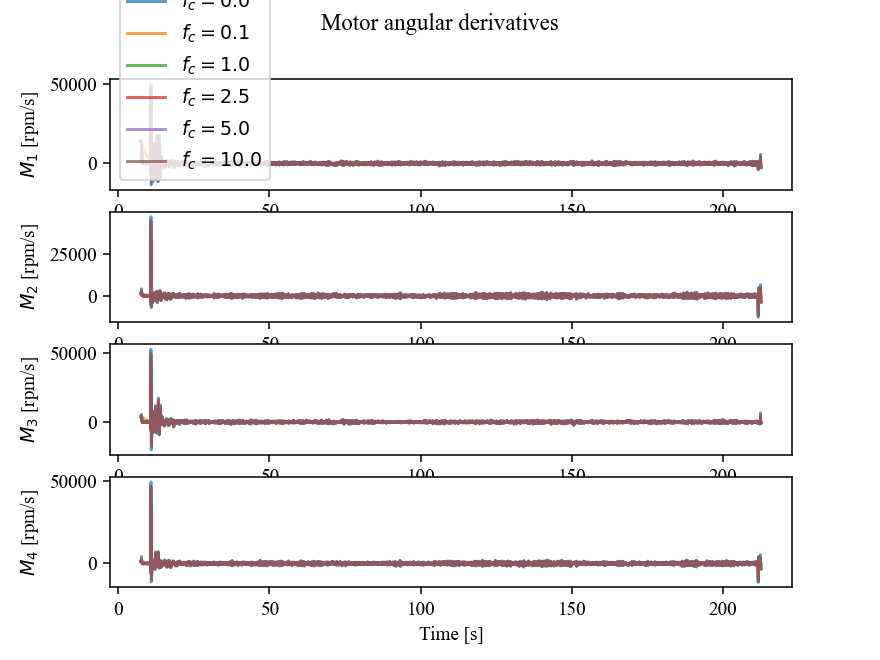

In [63]:
# Putting angular rates through a low pass
fig, ax = plt.subplots(4,1)

for fc in [0.,0.1, 1., 2.5, 5., 10.]:
    if fc == 0.:
        rpmdot_lp = rpmdot_est
    else:
        rpmdot_lp = adaptive_low_pass(t_motors, rpmdot_est, fc)
    ax[0].plot(t_motors, rpmdot_lp[:,0], alpha=0.75, label="$f_c = %.1f$" % fc)
    ax[1].plot(t_motors, rpmdot_lp[:,1], alpha=0.75)
    ax[2].plot(t_motors, rpmdot_lp[:,2], alpha=0.75)
    ax[3].plot(t_motors, rpmdot_lp[:,3], alpha=0.75)

    
fig.suptitle("Motor angular derivatives")
ax[0].legend()
ax[0].set_ylabel('$M_1$ [rpm/s]')
ax[1].set_ylabel('$M_2$ [rpm/s]')
ax[2].set_ylabel('$M_3$ [rpm/s]')
ax[3].set_ylabel('$M_4$ [rpm/s]')
ax[-1].set_xlabel('Time [s]')

plt.show()